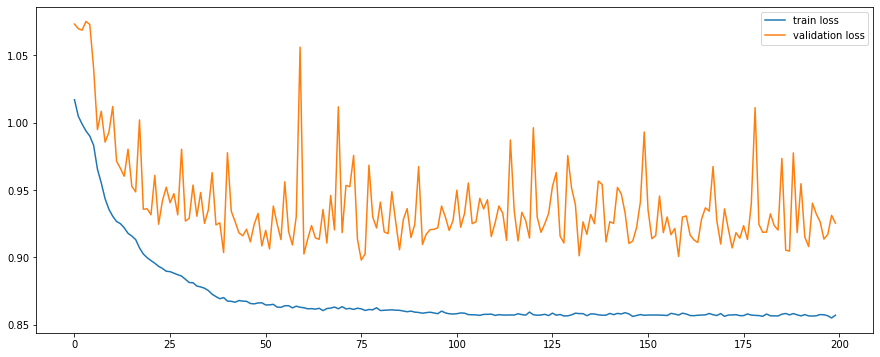

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm 
from sklearn.metrics import accuracy_score, classification_report
import math
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
train_losses = np.loadtxt('train_losses_vit0.01_10.txt')
test_losses = np.loadtxt('test_losses_vit0.01_k10.txt')
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')
plt.legend()

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)

    dY = np.array(Y)

    dataY = dY[T - 1:N] - 1

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY

def torch_data(x, y):
    x = torch.from_numpy(x)
    x = torch.unsqueeze(x, 1)
    y = torch.from_numpy(y)
    y = F.one_hot(y, num_classes=3)
    return x, y
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, k, num_classes, T):
        """Initialization""" 
        self.k = k
        self.num_classes = num_classes
        self.T = T
            
        x = prepare_x(data)
        y = get_label(data)
        x, y = data_classification(x, y, self.T)
        y = y[:,self.k]
        self.length = len(x)

        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]
    

root_train = '/tf/data/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training'
root_test = '/tf/data/BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing'
train_data_path = root_train + '/Train_Dst_NoAuction_ZScore_CF_7.txt'
test_data_path1 = root_test + '/Test_Dst_NoAuction_ZScore_CF_7.txt'
test_data_path2 = root_test + '/Test_Dst_NoAuction_ZScore_CF_8.txt'
test_data_path3 = root_test + '/Test_Dst_NoAuction_ZScore_CF_9.txt'

dec_data = np.loadtxt(train_data_path)
dec_test1 = np.loadtxt(test_data_path1)
dec_test2 = np.loadtxt(test_data_path2)
dec_test3 = np.loadtxt(test_data_path3)

dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_train.shape, dec_val.shape, dec_test.shape)

batch_size = 32

dataset_train = Dataset(data=dec_train, k=4, num_classes=3, T=100)
dataset_val = Dataset(data=dec_val, k=4, num_classes=3, T=100)
dataset_test = Dataset(data=dec_test, k=4, num_classes=3, T=100)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

cuda:1
(149, 203800) (149, 50950) (149, 139587)
torch.Size([203701, 100, 40]) torch.Size([203701])


In [3]:
model = torch.load('best_val_model_pytorch')

n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = F.softmax(model(inputs), dim=1)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

Test acc: 0.6010


In [4]:
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = F.softmax(model(inputs), dim=1)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)

In [5]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))


accuracy_score: 0.601040949759119
              precision    recall  f1-score   support

           0     0.5593    0.5311    0.5448     47915
           1     0.7270    0.6771    0.7012     48050
           2     0.5251    0.5941    0.5575     43523

    accuracy                         0.6010    139488
   macro avg     0.6038    0.6008    0.6012    139488
weighted avg     0.6064    0.6010    0.6026    139488

